In [23]:
import pandas as pd
from pathlib import Path
import unicodedata
import re

def limpar_coluna(col):
    col = col.strip().lower()
    col = unicodedata.normalize('NFKD', col).encode('ascii', 'ignore').decode('utf-8')

    col = col.replace("r$", "rs").replace("u$", "us")
    col = col.replace("(", "").replace(")", "").replace("*", "")
    col = re.sub(r'[^a-z0-9]+', '_', col)     # substitui qualquer sequência de não-letras/números por "_"
    col = re.sub(r'_+', '_', col)             # substitui múltiplos "_" por um só
    col = col.strip('_')                      # remove "_" do início e fim, se houver

    # ajuste específico para 'programa_desligamento_voluntario'
    col = col.replace('programa_desligamento_voluntario', 'pdv')
    col = col.replace('verbas_indenizatorias_registradas_em_sistemas_de_pessoal', 'verbas_indenizatorias')
    return col



# Configurar o mês e o ano desejado
ano = 2024
mes = 9
ano_mes = f"{ano}{str(mes).zfill(2)}"

# Caminho para os arquivos
base_dir = Path("../../../dados/dados_siape_bruto/descompactado")
pasta = base_dir / f"{ano_mes}_Servidores_SIAPE"
cadastro_csv = pasta / f"{ano_mes}_Cadastro.csv"
remuneracao_csv = pasta / f"{ano_mes}_Remuneracao.csv"

# Carregar os dados
df_c = pd.read_csv(cadastro_csv, encoding="iso-8859-1", sep=";", low_memory=False)
df_r = pd.read_csv(remuneracao_csv, encoding="iso-8859-1", sep=";", low_memory=False)
df = pd.merge(df_c, df_r, on="Id_SERVIDOR_PORTAL", how="left")

# Converter colunas monetárias
def para_float(valor):
    try:
        if isinstance(valor, str):
            valor = valor.replace('.', '').replace(',', '.')
        return float(valor)
    except:
        return None

df.columns = [limpar_coluna(c) for c in df.columns]
df["ano"] = str(ano)
df["mes"] = int(mes)

display (df.columns)

for col in [c for c in df.columns if "rs" in c or "us" in c or "remuneracao" in c or "verbas" in c]:
    df[col] = df[col].apply(para_float)
for col in [c for c in df.columns if "data_" in c]:
    df[col] = pd.to_datetime(df[col], errors="coerce", dayfirst=True)
if "id" in df.columns:
    df.drop(columns=["id"], inplace=True)

# Verificar valores maiores que BIGINT
BIGINT_MAX = 9223372036854775807

for col in df.select_dtypes(include=["int64", "float64"]).columns:
    if (df[col] > BIGINT_MAX).any():
        valores_errados = df[df[col] > BIGINT_MAX][col]
        print(f"🚨 Coluna `{col}` tem {len(valores_errados)} valores acima de BIGINT:")
        print(valores_errados)

df = df.drop(columns=[col for col in df.columns if "_us" in col])

Index(['id_servidor_portal', 'nome_x', 'cpf_x', 'matricula', 'descricao_cargo',
       'classe_cargo', 'referencia_cargo', 'padrao_cargo', 'nivel_cargo',
       'sigla_funcao', 'nivel_funcao', 'funcao', 'codigo_atividade',
       'atividade', 'opcao_parcial', 'cod_uorg_lotacao', 'uorg_lotacao',
       'cod_org_lotacao', 'org_lotacao', 'cod_orgsup_lotacao',
       'orgsup_lotacao', 'cod_uorg_exercicio', 'uorg_exercicio',
       'cod_org_exercicio', 'org_exercicio', 'cod_orgsup_exercicio',
       'orgsup_exercicio', 'cod_tipo_vinculo', 'tipo_vinculo',
       'situacao_vinculo', 'data_inicio_afastamento',
       'data_termino_afastamento', 'regime_juridico', 'jornada_de_trabalho',
       'data_ingresso_cargofuncao', 'data_nomeacao_cargofuncao',
       'data_ingresso_orgao', 'documento_ingresso_servicopublico',
       'data_diploma_ingresso_servicopublico', 'diploma_ingresso_cargofuncao',
       'diploma_ingresso_orgao', 'diploma_ingresso_servicopublico',
       'uf_exercicio', 'ano', 'mes

In [24]:
df_eu = df[df['nome_x'].str.lower().str.startswith("fernando augusto sampaio")]

# Selecionar colunas com valores monetários
colunas = [c for c in df_eu.columns if "rs" in c or "us" in c or "remuneracao" in c or "verbas" in c]

# Criar dicionário de formatação para todas as colunas monetárias
formato_dinheiro = {
    col: lambda x: x if pd.isnull(x) or x == "..." else f"R$ {x:,.2f}" for col in colunas
}

# Exibir tabela formatada
display(df_eu[["nome_x", "uorg_lotacao", "uorg_exercicio","ano","mes"] + colunas].style
    .format(formato_dinheiro)
    .hide(axis="index")
)


nome_x,uorg_lotacao,uorg_exercicio,ano,mes,remuneracao_basica_bruta_rs,abate_teto_rs,gratificacao_natalina_rs,abate_teto_da_gratificacao_natalina_rs,ferias_rs,outras_remuneracoes_eventuais_rs,irrf_rs,pss_rpgs_rs,demais_deducoes_rs,pensao_militar_rs,fundo_de_saude_rs,taxa_de_ocupacao_imovel_funcional_rs,remuneracao_apos_deducoes_obrigatorias_rs,verbas_indenizatorias_civil_rs,verbas_indenizatorias_militar_rs,verbas_indenizatorias_pdv_mp_792_2017_rs,total_de_verbas_indenizatorias_rs
FERNANDO AUGUSTO SAMPAIO BONAFE FERNANDES,ALF/VCP/ALF RFB NO AER INT VIRACOPOS,SRRF/8RF/SUPERINTENDENCIA REG RFB 8A RF,2024,9,"R$ 20,963.43",R$ 0.00,R$ 0.00,R$ 0.00,R$ 0.00,"R$ 1,984.19","R$ -4,485.51",R$ -908.85,"R$ -1,677.25",R$ 0.00,R$ 0.00,R$ 0.00,"R$ 15,876.01","R$ 1,267.68",R$ 0.00,R$ 0.00,"R$ 1,267.68"


In [25]:
df_eu = df[df['nome_x'].str.lower().str.startswith("fernando augusto sampaio")]

# Selecionar colunas com valores monetários
colunas = [c for c in df_eu.columns if "rs" in c or "us" in c or "remuneracao" in c or "verbas" in c]

registro = df_eu[["nome_x", "uorg_lotacao", "uorg_exercicio", "ano", "mes"] + colunas].iloc[0]
registro_formatado = registro.copy()

# Aplicar formatação nas colunas de dinheiro
for col in colunas:
    val = registro[col]
    if pd.notnull(val) and val != "...":
        registro_formatado[col] = f"R$ {val:,.2f}"

# Mostrar como campo em cima de campo
display(registro_formatado.to_frame(name="Valor"))

,Valor
nome_x,FERNANDO AUGUSTO SAMPAIO BONAFE FERNANDES
uorg_lotacao,ALF/VCP/ALF RFB NO AER INT VIRACOPOS
uorg_exercicio,SRRF/8RF/SUPERINTENDENCIA REG RFB 8A RF
ano,2024
mes,9
remuneracao_basica_bruta_rs,"R$ 20,963.43"
abate_teto_rs,R$ 0.00
gratificacao_natalina_rs,R$ 0.00
abate_teto_da_gratificacao_natalina_rs,R$ 0.00
ferias_rs,R$ 0.00


In [ ]:
import pandas as pd
from IPython.display import display, Markdown

# Mostrar título e explicação
display(Markdown("""
# 🧾 Portal da Transparência - Base SIAPE

## 🔍 Análise agrupada por **Descrição do Cargo**

Agrupamento dos dados com base no campo `DESCRICAO_CARGO`, ordenado pelo **Quantidade de servidores** decrescente.
"""))

# Agrupar
resumo = df.groupby("descricao_cargo").agg({
    "remuneracao_basica_bruta_rs": ["sum", "count", "mean"]
})
resumo.columns = ["Total remuneração cargo", "Quantidade de servidores", "Média da remuneração"]
resumo = resumo.sort_values(by="Quantidade de servidores", ascending=False)
resumo = resumo.reset_index()

# Adiciona ranking
resumo.insert(0, "Posição", range(1, len(resumo) + 1))

# Cargos a destacar
cargos_destacados = [
    "AUDITOR-FISCAL DA RECEITA FEDERAL BRASIL",
    "ANALISTA TRIBUTARIO REC FEDERAL BRASIL"
]

# Extrair os dados que você quer mostrar:
top_n = 15
linhas_destaque = resumo[resumo["descricao_cargo"].isin(cargos_destacados)]
parte_inicial = resumo.iloc[:top_n]

# Criar linha de reticências
linha_reticencias = pd.DataFrame([["...", "...", "...", "...", "..."]], columns=resumo.columns)

# Concatenar tudo
resumo_final = pd.concat([
    parte_inicial,
    linha_reticencias,
    linhas_destaque
], ignore_index=True)

# Função para destacar os cargos desejados
def destacar_cargos_condicional(linha):
    if linha["descricao_cargo"] in cargos_destacados:
        return ['background-color: #ffe599'] * len(linha)
    return [''] * len(linha)

# Formatar e exibir
display(resumo_final.style
    .format({
        "Total remuneração cargo": lambda x: x if x == "..." else "R$ {:,.2f}".format(x),
        "Quantidade de servidores": lambda x: x if x == "..." else "{:,}".format(x),
        "Média da remuneração": lambda x: x if x == "..." else "R$ {:,.2f}".format(x)
    })
    .apply(destacar_cargos_condicional, axis=1)
    .hide(axis="index")
)


In [ ]:
import pandas as pd
from IPython.display import display, Markdown

# Mostrar título e explicação
display(Markdown("""
# 🧾 Portal da Transparência - Base SIAPE

## 🔍 Análise agrupada por **Descrição do Cargo**

Agrupamento dos dados com base no campo `DESCRICAO_CARGO`, ordenado pelo **Quantidade de servidores** decrescente.
"""))

# Selecionar colunas com valores monetários
colunas = [c for c in df.columns if "rs" in c or "us" in c or "remuneracao" in c or "verbas" in c]

# Filtrar por cargo específico
df_cargo = df[df['descricao_cargo'] == "AUDITOR-FISCAL DA RECEITA FEDERAL BRASIL"]
df_cargo = df_cargo.sort_values(by="remuneracao_basica_bruta_rs", ascending=False)

# Criar dicionário de formatação para todas as colunas monetárias
formato_dinheiro = {
    col: lambda x: x if pd.isnull(x) or x == "..." else f"R$ {x:,.2f}" for col in colunas
}

# Exibir tabela formatada
display(df_cargo[["nome_x", "uorg_lotacao", "uorg_exercicio"] + colunas].style
    .format(formato_dinheiro)
    .hide(axis="index")
)


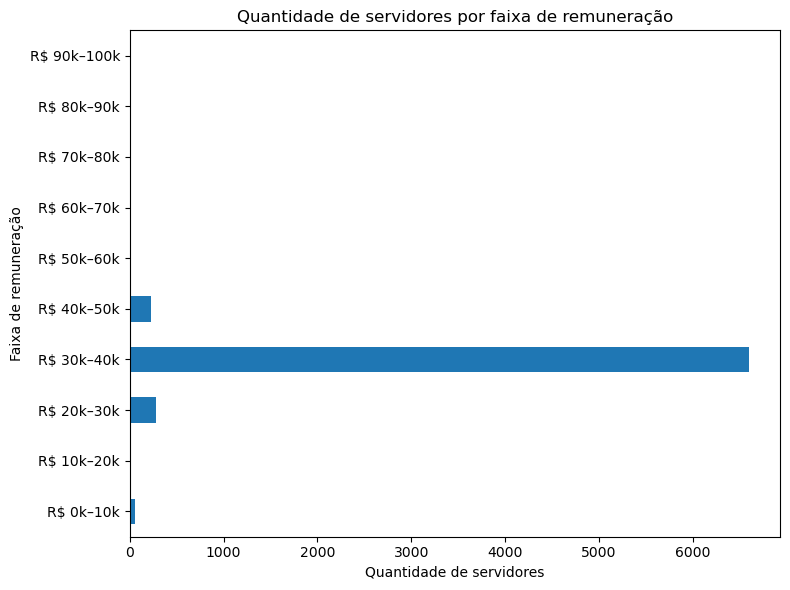

In [19]:
import pandas as pd

# Garantir que a coluna está numérica (caso tenha sido importada como string)
df_cargo["remuneracao_basica_bruta_rs"] = pd.to_numeric(df_cargo["remuneracao_basica_bruta_rs"], errors="coerce")

# Criar as faixas (bins) de 0 a 100 mil, de 10 em 10 mil
bins = range(0, 110_000, 10_000)
labels = [f"R$ {i//1000}k–{j//1000}k" for i, j in zip(bins[:-1], bins[1:])]

# Criar a coluna de faixa
df_cargo["faixa_remuneracao"] = pd.cut(df_cargo["remuneracao_basica_bruta_rs"], bins=bins, labels=labels, right=False)

# Contar quantos servidores em cada faixa
grupos = df_cargo["faixa_remuneracao"].value_counts().sort_index()

# Exibir de forma bonita
import matplotlib.pyplot as plt

grupos.plot(kind='barh', figsize=(8, 6), title='Quantidade de servidores por faixa de remuneração')
plt.xlabel("Quantidade de servidores")
plt.ylabel("Faixa de remuneração")
plt.tight_layout()
plt.show()
